##### **Imports**

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.stats import expon, norm
from scipy.optimize import minimize
from matplotlib.ticker import AutoMinorLocator

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,  roc_curve, auc, precision_score

import warnings
warnings.filterwarnings("ignore")

colors = ['crimson','midnightblue', 'magenta','orange','springgreen','dodgerblue','darkviolet', 'olive','tomato']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

##### **Problem 1a**

Get data and separate into training/test sets

In [55]:
data = pd.read_csv('earning_potential_train_test.txt', sep=',',header=0)
data['label'] = data['earning'].apply(lambda x: 1 if x== ' >50K' else 0)

In [56]:
label_counts = data['label'].value_counts()
data.drop(columns=['label'], inplace=True)
ratio = label_counts[1]/label_counts[0]

print(f'There are {label_counts[1]} high-earners and {label_counts[0]} low-earners. This is a ratio of {ratio:.3}')
print(f'We choose a ratio of 54:46 training:test ratio, as this will give 502 test samples. The ratio above is also preserved')

There are 1091 high-earners and 3409 low-earners. This is a ratio of 0.32
We choose a ratio of 54:46 training:test ratio, as this will give 502 test samples. The ratio above is also preserved


Classifier

In [57]:
### Mask the data ie. split the data
high_earners = (data['earning'] == ' >50K')
low_earners = (data['earning'] == ' <=50K')

### Extract the feature columns
x_high = data.iloc[:,:4][high_earners]
x_low = data.iloc[:,:4][~high_earners]

### Labels
y_high = np.ones(1091)
y_low = np.zeros(3409)

In [58]:
### Get data
x_high_training, x_high_testing, y_high_training, y_high_testing = train_test_split(x_high, y_high, test_size=0.46, random_state=42)
x_low_training, x_low_testing, y_low_training, y_low_testing = train_test_split(x_low, y_low, test_size=0.46, random_state=42)

# Prepare and combine the data sets
x_training = np.vstack([x_high_training, x_low_training])
x_testing = np.vstack([x_high_testing, x_low_testing])

y_training = np.hstack([y_high_training, y_low_training])
y_testing = np.hstack([y_high_testing, y_low_testing])

In [59]:
### Shuffle the data
shuffle_training_data = np.random.permutation(len(y_training))
x_training = x_training[shuffle_training_data]
y_training = y_training[shuffle_training_data]

shuffle_testing_data = np.random.permutation(len(y_testing))
x_testing = x_training[shuffle_testing_data]
y_testing = y_training[shuffle_testing_data]

In [60]:
### Model
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=1,
                      learning_rate=0.1, use_label_encoder=False, n_estimators=75, 
                      max_depth=4)

model.fit(x_training, y_training)

Y_preds = model.predict(x_testing) # Predicted labels
accuracy = accuracy_score(y_testing, Y_preds) # Get the accuracy scpre
print(f'The accuracy of the model with test data is {accuracy:.04}')

preds = model.predict_proba(x_testing) 
preds = pd.DataFrame(preds, columns=['low earner', 'high earner'])

The accuracy of the model with test data is 0.8204


Establish precision

In [63]:
preds_train = model.predict_proba(x_training) # Predict the probability on training data
preds_train = pd.DataFrame(preds_train, columns=['low earner', 'high earner'])

precisions = np.zeros(100)

for i in range(len(np.linspace(0,1,100))):
    
    predictions = np.zeros(len(preds_train['high earner']))
    
    mask_high = (preds_train['high earner'] > np.linspace(0,1,100)[i])
    
    predictions[mask_high] = 1
    
    precisions[i] = precision_score(y_true=y_training, y_pred=predictions)
    
id_of_cut = np.argmin(abs(precisions - 0.85))
precisions[id_of_cut]

0.8429752066115702

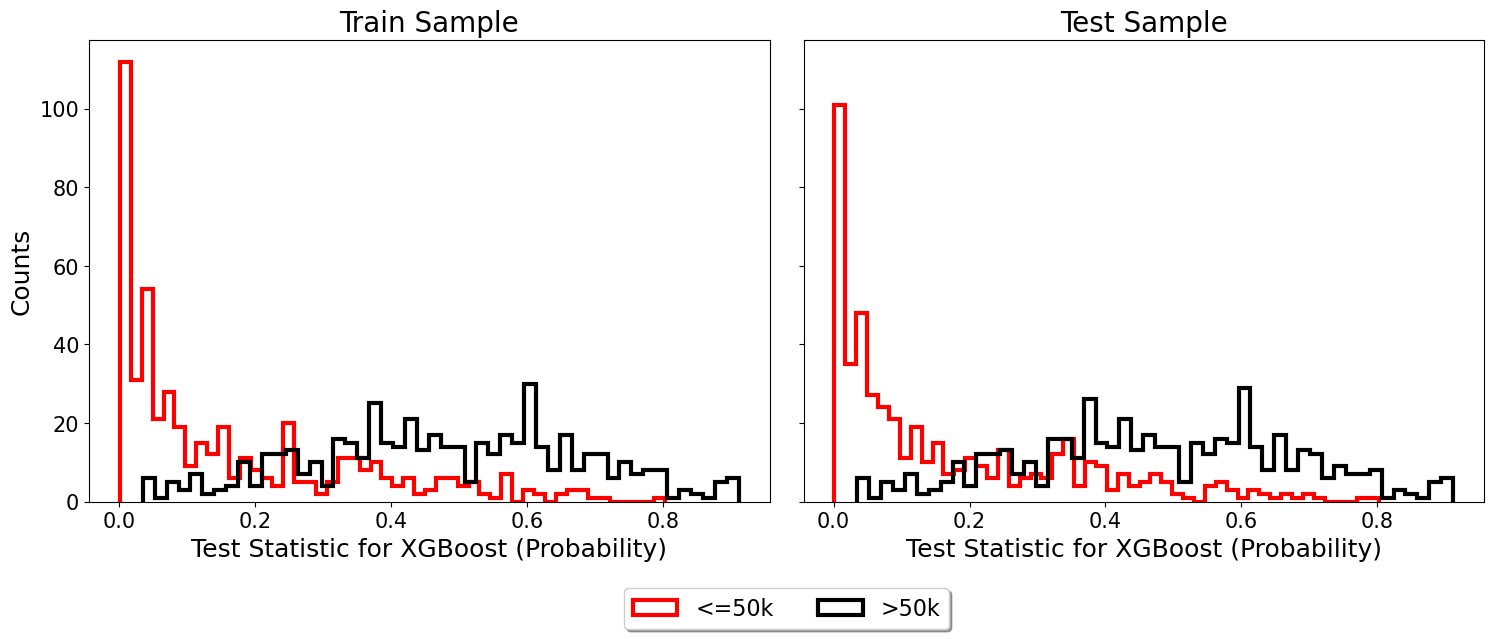

In [64]:
fig, ax = plt.subplots(ncols=2, figsize=(18,6))

ax[0].hist(preds_train['high earner'][y_training==0][:500], color='r', histtype='step', 
           bins=50, linewidth=3, label='<=50k')
ax[0].hist(preds_train['high earner'][y_training==1][:500], color='k', histtype='step', 
           bins=50, linewidth=3, label='>50k')

ax[0].tick_params(axis="x", labelsize=15) 
ax[0].tick_params(axis="y", labelsize=15) 
ax[0].set_ylabel('Counts', fontsize=18)
ax[0].set_xlabel('Test Statistic for XGBoost (Probability)', fontsize=18)
ax[0].set_title('Train Sample', fontsize=20)

# Test sample ---------
ax[1].hist(preds['high earner'][y_testing==0][:500], color='r', histtype='step', 
           bins=50, linewidth=3, label='<=50k')
ax[1].hist(preds['high earner'][y_testing==1][:500], color='k', histtype='step', 
           bins=50, linewidth=3, label='>50k')

ax[1].legend(loc='lower center', prop={'size':16}, bbox_to_anchor=(-0.025, -0.3),
          ncol=3, fancybox=True, shadow=True)

ax[1].tick_params(axis="x", labelsize=15) 
ax[1].set_xlabel('Test Statistic for XGBoost (Probability)', fontsize=18)
ax[1].set_title('Test Sample', fontsize=20)
plt.show()

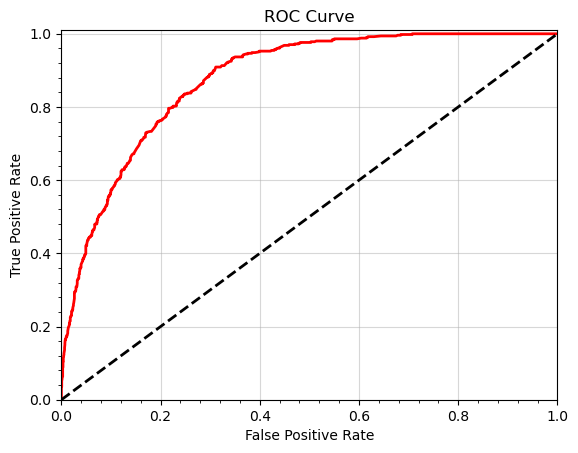

In [62]:
fpr, tpr, thresholds = roc_curve(y_testing,preds['high earner'])
roc_auc = auc(fpr, tpr)

plt.figure()
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='minor', length=2, color='k')

plt.plot(fpr, tpr, color='red', lw=2)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True,alpha=0.5,zorder=0)
ax.set_axisbelow(True)
plt.show()

##### **Problem 1b**